**Index**
+ 포인트 적립/사용 현황 : 폴 바셋
+ 일별 발급건수
+ 일별 사용건수
+ 당월 제품별 사용건수
+ 판매종료 제품 List : 엠즈씨드 DB와 비교

In [1]:
###############
# 0. import
#####

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import re
import time 

# local only
import os
import cx_Oracle as oci
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

# 내용공유(e-mail, 회사) 
import win32com.client
from glob import glob
import io
import base64
from PIL import Image


In [2]:
###############
# 1.데이터 불러오기
#####
# DB접속 : 접속정보 읽기
con_text = open("C:/Users/MAEIL/conn_info_MMBSHIP.txt", 'r', encoding='utf8')
con_text = con_text.read()

# DB 접속 : 실제 접속
conn = oci.connect(con_text[1:], encoding='UTF-8', nencoding='UTF-8')

In [3]:
###############
# 서비스 이용현황 전반
#####
query = '''
        select apv_dt
        , (select J.code_nm from jt_code J where trsc_typ_cd = J.code and code_grp_id = 'PM001') as code_nm
        , count(*) as cnt
        from tp_trsc_ptcl
        where coopco_Cd = 7030
        and substr(trsc_dt,1,6) = to_char(add_months(trunc(sysdate,'mm'),-1), 'YYYYMM')
        group by apv_dt, trsc_typ_cd
        '''
df_00 = pd.read_sql(query, con = conn )

In [4]:
report_00 = pd.pivot_table(df_00, values='CNT', index=['APV_DT'], columns=['CODE_NM'],  aggfunc='sum')
report_01 = pd.pivot_table(df_00, values='CNT', index=['CODE_NM'],  aggfunc='sum')

In [5]:
# report_00.fillna(0)

In [6]:
report_01

,CNT
CODE_NM,
관계사매장등록/수정,76
기프트카드사용/사용취소,4510
기프트카드충전/취소,174
메뉴교환권사용/사용취소,976
쿠폰발급,4911
쿠폰사용/사용취소,4455
크라운사용/사용취소,1178
크라운적립/적립취소,3962
포인트 사용/사용취소,506


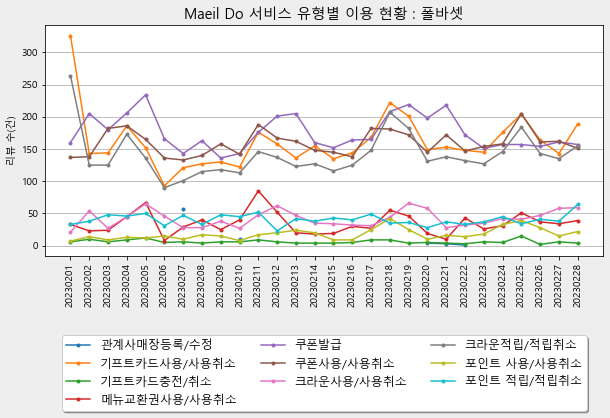

In [32]:
date2 = datetime.today().strftime('%Y%m%d')
image_name = date2[2:] +'_PBS_graph_01.png'

mpl.rc('figure', figsize=(10, 4))
fig = plt.figure( facecolor='#eeeeee')
# ax1 = plt.subplot2grid((1, 1), (0, 0), colspan=1)
plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.plot(report_00,'.-',  label=report_00.columns )
plt.legend(list(report_00.columns), loc='lower center', bbox_to_anchor=(0.5, -0.7), fancybox=True, shadow=True, ncol=3,fontsize='large')
plt.grid(True, axis='y')
plt.xticks(rotation=90)
# plt.title('일별 리뷰 수(제품별 Trend)',fontsize='x-large')
plt.ylabel('리뷰 수(건)')
plt.title('Maeil Do 서비스 유형별 이용 현황 : 폴바셋',fontsize='x-large')
plt.savefig(image_name, bbox_extra_artists=(), bbox_inches='tight', dpi=70)
# plt.show()

In [10]:
###############
# 발급일자 기준
#####
query = '''
        select P.vald_str_dt as reg_dt, count(*) as CNT
        From TPM_MNU_CPN_PCH P, TPM_MNU_CPN M
        where M.mnu_cpn_cd = P.mnu_cpn_cd
        and m.use_coopco_cd  = '7030'
        and substr(vald_str_dt,1,6) = to_char(add_months(trunc(sysdate,'mm'),-1), 'YYYYMM')
        group by P.vald_str_dt
        '''
df_01 = pd.read_sql(query, con = conn )
df_01['GUBUN'] ='메뉴교환권_발급'


In [11]:
###############
# 사용일자 기준
#####
query = '''
        select P.issu_dt as reg_dt, count(*) as CNT
        From TPM_MNU_CPN_PCH P, TPM_MNU_CPN M
        where P.cpn_st_cd ='2'
        and M.mnu_cpn_cd = P.mnu_cpn_cd
        and m.use_coopco_cd  = '7030'
        and substr(issu_dt,1,6) = to_char(add_months(trunc(sysdate,'mm'),-1), 'YYYYMM')
        group by P.issu_dt
        '''
df_02 = pd.read_sql(query, con = conn )
df_02['GUBUN'] ='메뉴교환권_사용'

In [12]:
df = pd.concat([df_01, df_02], ignore_index =True)

In [13]:
report_02 = pd.pivot_table(df, values='CNT', index=['REG_DT'],columns=['GUBUN'],  aggfunc='sum')

In [14]:
report_02['메뉴교환권_사용'].sum()

668

In [15]:
report_02.T.iloc[[0]][0:]

REG_DT,20230201,20230202,20230203,20230204,20230205,20230206,20230207,20230208,20230209,20230210,...,20230219,20230220,20230221,20230222,20230223,20230224,20230225,20230226,20230227,20230228
GUBUN,,,,,,,,,,,,,,,,,,,,,
메뉴교환권_발급,31,26,22,37,54,19,25,37,25,73,...,26,23,15,45,33,22,48,34,39,57


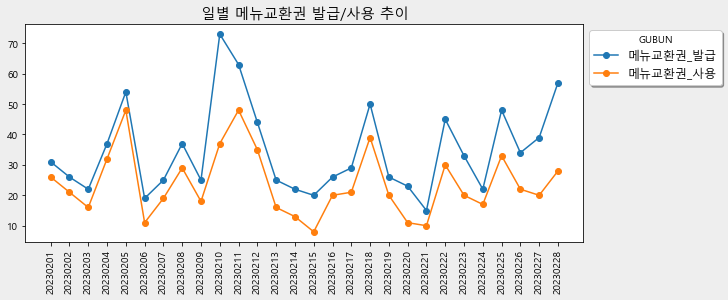

In [16]:
date2 = datetime.today().strftime('%Y%m%d')
image_name = date2[2:] +'_PBS_graph_02.png'

mpl.rc('figure', figsize=(10, 4))
fig = plt.figure( facecolor='#eeeeee')
plt.plot(report_02,'o-',  label=report_02.columns )
# plt.legend(list(report_02.columns), loc='lower center', bbox_to_anchor=(0.5, -0.7), fancybox=True, shadow=True, ncol=3,fontsize='large')
plt.legend(report_02.columns, title=report_02.columns.name, loc='upper left', bbox_to_anchor=(1, 1), fancybox=True, shadow=True, ncol=1,fontsize='large')
plt.xticks(rotation=90)
plt.title('일별 메뉴교환권 발급/사용 추이',fontsize='x-large')
plt.savefig(image_name,  bbox_inches='tight', dpi=70, facecolor='#eeeeee')
plt.show()

In [17]:
###############
# 제품 List : 발급된 제품 List 
#####
query = '''
        select m.relco_prdct_cd as item_cd, m.prdct_nm, count(*) as CNT
        From TPM_MNU_CPN_PCH P, TPM_MNU_CPN M
        where P.cpn_st_cd ='2'
        and M.mnu_cpn_cd = P.mnu_cpn_cd
        and m.use_coopco_cd  = '7030'
        and substr(issu_dt,1,6) = to_char(add_months(trunc(sysdate,'mm'),-1), 'YYYYMM')
        group by M.relco_prdct_cd, m.prdct_nm
        order by 3 desc
        '''
df_03 = pd.read_sql(query, con = conn )

In [18]:
df_03['ITEM_CD'] = df_03['ITEM_CD'].astype(str)

### 판매종료 제품 List : 지난달 판매된 엠즈씨드 제품과 비교

In [19]:
# DB접속 : 접속정보 읽기
con_text = open("C:/Users/MAEIL/conn_MCRM.txt", 'r', encoding='utf8')
con_text = con_text.read()

# DB 접속 : 실제 접속
conn = oci.connect(con_text, encoding='UTF-8', nencoding='UTF-8')

In [20]:
query = '''
        select distinct item_cd , 'Y' as USE_YN
        from sale_jmm
        where sale_ym = to_char(add_months(trunc(sysdate,'mm'),-1), 'YYYYMM')
        '''
df_product = pd.read_sql(query, con = conn )

In [21]:
df_product['ITEM_CD'] = df_product['ITEM_CD'].astype(str)

In [22]:
report_03 = pd.merge(df_03, df_product, on='ITEM_CD', how='left')

In [23]:
report_03

,ITEM_CD,PRDCT_NM,CNT,USE_YN
0,170134,아이스 룽고(Standard),114,Y
1,170039,상하목장 밀크 아이스크림(컵),110,Y
2,179437,아이스크림 라떼(Standard),97,Y
3,170040,상하목장 밀크 아이스크림(콘),47,Y
4,170054,룽고(Standard),47,Y
5,170157,아이스 카페라떼(Standard),42,Y
6,170080,카페라떼(Standard),32,Y
7,179761,아이스 바닐라 라떼(Standard),32,Y
8,179767,New 발로나 초콜릿 프라페,19,Y
9,179876,아이스 제주말차라떼(Standard),17,Y


In [24]:
# 이미지파일 정렬
path = ''
list_of_images = glob(os.path.join(path, "*PBS_graph*") )


# 이미지 파일 : 변환모듈 
def image_to_base64(image_name):
    img = Image.open("./"+ image_name)
    bytearr = io.BytesIO()
    img.save(bytearr, format="png")
    imgbytearr = bytearr.getvalue()
    encoded_image = base64.b64encode(imgbytearr).decode("utf-8")
    return encoded_image


In [25]:
(datetime.today()).strftime('%Y-%m')

'2023-03'

In [27]:
from jinja2 import Template

In [33]:
# 이메일 양식(내용) frame 구성하기
message_tmpl="""
<html>
    <!DOCTYPE html>
    <html>
    <head lang ="ko">
      <meta charset ="UTF-8">
      <title>{{title1}}</title>
    </head>
    <style type="text/css">
        table, th, td {
            font-size: 8pt;
            border-collapse: collapse;
            font-family: Malgun Gothic;
            white-space: nowrap;
            border: 1px solid #bcbcbc;
            }
        thead tr {
            background-color: #0d47a1;
            color: #ffffff;
            }
    </STYLE>
    <BODY style="FONT-SIZE: 10pt; font-family: Malgun Gothic">
    안녕하세요,<br>
    <br>
    {{send_date}}월 기준, 폴바셋 메뉴교환권 이용현황 공유드립니다.<br>
    <br>
    <b>1. 전월 서비스 운영 전반 </b><br>
    <img src="data:image/png;base64,{{image_00}}"/><br>
    <br>
    <b>2. 메뉴교환권 발급 및 사용 Trend</b><br>
    <img src="data:image/png;base64,{{image_01}}"/><br>
    <br>
    <b>3. 메뉴교환권 사용 현황 : 제품별 사용겟수 & 이슈</b><br>
    {{ df3_html }}<br>
    <SPAN>{{df3_text}}</SPAN><br>
    <br>
    <SPAN style="COLOR: #808080">{{add_text1}}</SPAN><br>
    <SPAN style="COLOR: #808080">{{add_text2}}</SPAN><br>
    <br>
    감사합니다.<br>
    <br>
    </BODY>
</html>"""

# 이메일 양식(내용) 변동 내용 정의
render_data = {
    'send_date' : (datetime.today()- timedelta(days = 4)).strftime('%Y-%m')[:7],
    'df3_html' : report_03.to_html(),
    'image_00' : image_to_base64(list_of_images[0]),
    'image_01' : image_to_base64(list_of_images[1]),
    'df3_text' : '* (확인필요)로 표기된 메뉴는, 폴 바셋에서 판매되지 않았으나 사용처리된 메뉴교환권을 의미합니다.' ,
    'add_text1' : "*  본 메일은 발신전용입니다.",
    'add_text2' : "** (내용/기술문의 : 고객정보전략담당, 박경하 )"
}

t= Template(message_tmpl)
html_report = t.render(render_data)


In [34]:
# 발송 변수 설정

to_users = 'O000000804@maeil.com'
to_cc    = ''


# 메일제목
now = datetime.today()    # 현재
date = now.strftime('%Y%m%d')

subject = "[자동발송] 폴 바셋의 Maeil Do서비스 이용 현황_v1"

# 본문
html = html_report

# 첨부파일 추가
attach = None


#메일 발송
import win32com.client

outlook = win32com.client.Dispatch("Outlook.Application")
send_mail = outlook.CreateItem(0)

send_mail.To = to_users #메일 수신인
send_mail.CC = to_cc #메일 수신인

send_mail.Subject = subject #메일 제목
send_mail.HTMLBody =html_report

In [35]:
send_mail.Display(True)